In [1]:
"""
concurrency.py

This script demonstrates a rudimentary concurrent trading system using the TWS API.
It combines multiple data streams—account updates, position updates, market scanner subscription,
and real-time market data (tickPrice)—to decide when to enter or exit trades.

The system uses threading to ensure that the API's event loop runs concurrently with our main code.
Throughout the code, extensive comments are provided to explain the logic and how each component works.
The trading strategy used here is improved compared to a basic demo:
    - It monitors account cash and will disconnect if the TotalCashBalance falls below an amount.
    - It requests position updates to track current holdings, preventing unintended short positions.
    - It uses a market scanner to subscribe to the top MOST_ACTIVE stocks on major U.S. exchanges.
    - For each of the top five scanner results, it subscribes to market data.
    - In the tickPrice callback, it compares the new tick price to the previously stored price.
      • If the price rises more than a % AND no current position exists, it triggers a BUY order.
      • If the price falls more than a % AND a position is currently held, it triggers a SELL order.
    - The strategy uses a fixed order quantity (with a slight variation if adding to an existing position).
    - All these functions operate concurrently via the TWS API's event loop.
"""

from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.tag_value import TagValue
from ibapi.order import Order
from ibapi.contract import Contract
from ibapi.scanner import ScannerSubscription

import datetime
import time
import threading

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import logging
# Configure logging to output INFO-level messages on the console
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

In [2]:
class TestApp(EClient, EWrapper):
    """
    This class subscribes to IB account and portfolio updates.
    
    At the end of the first complete update cycle (signaled via accountDownloadEnd),
    the final StockMarketValue is saved as the shares_init_amount in self.shares_init_amount.
    
    Then, in every subsequent real-time update (in updateAccountValue) when the key
    is "StockMarketValue", the current value is compared against self.shares_init_amount. If the
    StockMarketValue drops by more than the allowed threshold, we disconnect.

    """
    
    def __init__(self, max_perc_loss, n_stocks_scanner, req_snapshot):
        # Initialize the EClient with self as the wrapper.
        EClient.__init__(self, self)
        self.max_perc_loss = max_perc_loss  # For example, 0.05 means 5% loss threshold.

        # Account values.
        self.TotalCashBalance = {}          
        self.NetLiquidation = None
        self.StockMarketValue = None

        # Portfolio details.
        self.portfolio = {}
        self.curr_portfolio = None 
        self.position_ref = {}

        # For storing aggregated values per update cycle (not strictly needed for shares_init_amount check).
        self.total_owned = {}    # Overall account value (NetLiquidation)
        self.total_shares = {}   # StockMarketValue

        # Account time for each update cycle.
        self.account_time = None

        # The dedicated shares_init_amount variable (set once at the end of the first update cycle).
        self.shares_init_amount = None

        # Scanner contracts retrieved
        self.ScannerResults = {}
        self.tick_history = []

        self.n_stocks_scanner = n_stocks_scanner
        self.next_id = 0
        self.req_snapshot = req_snapshot

        


    def nextValidId(self, orderId: int):
        pass


    
    def nextId(self) -> int:
        self.next_id += 1
        return self.next_id


        
    def error(self, reqId: int, errorTime: int, errorCode: int, 
              errorString: str, advancedOrderReject=""):
        pass
        # print(f"Error - reqId:{reqId}, errorTime:{errorTime}, errorCode:{errorCode}, "
        #       f"errorString:{errorString}, OrderReject:{advancedOrderReject}")

    
    
    def updateAccountValue(self, key: str, val: str, currency: str, accountName: str):
        """
        Called repeatedly during the account update cycle.
        This callback simply stores the incoming values.
        Also, for "StockMarketValue" updates that come in after the shares_init_amount has been set,
        a real-time safety check is performed.
        """
        if key == "TotalCashBalance":
            self.TotalCashBalance[currency] = float(val)
        elif key == "NetLiquidation":
            self.NetLiquidation = float(val)
        elif key == "StockMarketValue":
            self.StockMarketValue = float(val)
            
        if (self.shares_init_amount is not None  # wait for the initial amount to be processed in the 'accountDownloadEnd' method 
        and self.portfolio != self.curr_portfolio): # to add the new portfolio value only if it has been updated
            self.total_owned[self.account_time] = self.NetLiquidation
            shares_curr_amount = round(sum(self.portfolio.values()),2)
            self.total_shares[self.account_time] = shares_curr_amount
            print('[EXEC "updateAccountValue"] TotalCashBalance:', self.TotalCashBalance)
            print('[EXEC "updateAccountValue"] Current Portfolio:', self.portfolio)
            print('[EXEC "updateAccountValue"] Total EUR owned amounts:', self.total_owned)
            print('[EXEC "updateAccountValue"] Total USD shares amounts:', self.total_shares)
            self.curr_portfolio = self.portfolio.copy()
    
            #safety check (disconnect if shares amount drops below a threshold)
            if shares_curr_amount < self.shares_init_amount * (1 - self.max_perc_loss):
                print(f"shares_curr_amount {shares_curr_amount:.2f} "
                      f"is lower than the shares_init_amount {self.shares_init_amount:.2f} "
                      f"(a drop of more than {self.max_perc_loss:.2f}%).")
                print("Disconnecting for safety!")
                self.disconnect()

    
                
    def updatePortfolio(self, contract: Contract, position: float, marketPrice: float,
                        marketValue: float, averageCost: float, unrealizedPNL: float,
                        realizedPNL: float, accountName: str):
        """
        Called for each portfolio update.
        We store the market value for each stock keyed by the contract symbol.
        """
        self.portfolio[contract.symbol] = marketValue

    
    
    def updateAccountTime(self, timeStamp: str):
        """
        Saves the account time for the current update cycle.
        """
        self.account_time = timeStamp

    
    
    def accountDownloadEnd(self, accountName: str):
        """
        Called when the entire batch of account (and portfolio) updates is finished.
        We perform our final processing here.
        """
        # Set the shares_init_amount (if set here, and not directly in the 'updateAccountValue' method, it stores the correct result)
        if self.shares_init_amount is None:
            self.shares_init_amount = self.StockMarketValue
            print('[EXEC "accountDownloadEnd"] shares_init_amount:', self.shares_init_amount)



    def position(self, account, contract: Contract, position, avgCost):
        """
        Callback: Receives updates for positions held.
        We record the current position for each symbol in our position_ref dictionary,
        ensuring that trading logic can check current holdings to avoid short positions.
        """
        self.position_ref[contract.symbol] = float(position)
        # print(f'[EXEC "position"] {contract.symbol}: Position = {position}, AvgCost = {avgCost}')
        next_id = self.nextId()
        self.ScannerResults[next_id] = {
                                        "ConId": contract.conId,
                                        "Symbol": contract.symbol,
                                        "SecType": contract.secType,
                                        "Exchange": contract.exchange,
                                        "Currency": contract.currency,
                                        # add any other properties you need...
                                        }        
        self.reqMktData(reqId = next_id, # to provide a different reqId for each contract
                       contract = contract, 
                       genericTickList = "", # A coma delimited list of generic tick types (?)
                       snapshot = self.req_snapshot, 
                       regulatorySnapshot = False, 
                       mktDataOptions = []) 



    def positionEnd(self):
        """This is called once all position data for a given request are
        received and functions as an end marker for the position() data."""
        pass

    

    def scannerParameters(self, xml: str):
        """Provides the xml-formatted parameters available to create a marketscanner """
        with open("scanner_parameters.xml", "w", encoding="utf-8") as file:
            file.write(xml)

        
    
    def scannerData(self, reqId, rank, contractDetails, distance, benchmark, projection, legsStr):
        """
        Callback: Receives results from a market scanner subscription.
        We limit our processing to the top 'n_stocks_scanner' results.
        We add the scanned contracts to the position_ref dictionaty with an initial value of 0.
        Later, when we receive an update about the actual holdings through the 'position' callback, the same dictionary entry is updated with the real position value. 
        This way, if we’re already holding some shares of that instrument, the actual position update will overwrite the 0 that the scanner set.
        """
        self.contractDetails = contractDetails
        if rank < self.n_stocks_scanner:
            next_id = self.nextId()
            self.ScannerResults[next_id] = {
                                            "ConId": contractDetails.contract.conId,
                                            "Symbol": contractDetails.contract.symbol,
                                            "SecType": contractDetails.contract.secType,
                                            "Exchange": contractDetails.contract.exchange,
                                            "Currency": contractDetails.contract.currency,
                                            # add any other properties you need...
                                            }
            self.position_ref[self.contractDetails.contract.symbol] = 0 # Initialize our position for this contract to zero (avoid short positions)       
            
            # Call this function to request market data. The market data will be returned by the Callbacks --> 'tickPrice' and 'tickSize'
            self.reqMktData(reqId = next_id, # to provide a different reqId for each contract
                           contract = self.contractDetails.contract, 
                           genericTickList = "", # A coma delimited list of generic tick types (?)
                           snapshot = self.req_snapshot, 
                           regulatorySnapshot = False, 
                           mktDataOptions = []) 
            print(f'[EXEC "scannerData"] Rank {rank}: {self.contractDetails.contract.symbol} on {self.contractDetails.contract.exchange}')


    
    def scannerDataEnd(self, reqId):
        """
        Callback: Indicates that the market scanner subscription has finished sending data.
        Here, we cancel the scanner subscription to avoid duplicate data, but we do not disconnect.
        """
        self.cancelScannerSubscription(reqId)

    

    def tickString(self, reqId, tickType, value):
        pass
        # if reqId == self.next_id: # just printing the ScannerResults dictionary at the last reqId callback
        #     # we print ScannerResults here, even if its update is linked also to the callbacks: tickSize and tickPrice
        #     print('[EXEC "tickString"] ScannerResults:', self.ScannerResults) 


    
    def tickSize(self, reqId, tickType, size):
        """
        Market data tick size callback. Handles all size-related ticks.
        It adds available size data to the ScannerResults.
        """
        if tickType == 0:  # Bid Size
            self.ScannerResults[reqId]["Bid_size"] = int(size)
            self.ScannerResults[reqId]["TS_Bid_size"] = datetime.datetime.now().isoformat()
        elif tickType == 3:  # Ask Size
            self.ScannerResults[reqId]["Ask_size"] = int(size)
            self.ScannerResults[reqId]["TS_Ask_size"] = datetime.datetime.now().isoformat()
        elif tickType == 5:  # Last Size
            self.ScannerResults[reqId]["Last_size"] = int(size)
            self.ScannerResults[reqId]["TS_Last_size"] = datetime.datetime.now().isoformat()
        elif tickType == 8:  # Trading Volume
            self.ScannerResults[reqId]["Volume"] = int(size)
            self.ScannerResults[reqId]["TS_Volume"] = datetime.datetime.now().isoformat()
        
        # Record the update (this unified log call will filter out duplicates).
        self.record_tick_update(reqId)


    
        
    def tickPrice(self, reqId, tickType, price, attrib):
        """
        Market data tick price callback. Handles price-related ticks.
        Updates ScannerResults with the following fields:
          - Bid Price (tick type 1)
          - Ask Price (tick type 2)
          - Last Price (tick type 4, when valid)
          - High Price for the day (tick type 6)
          - Low Price for the day (tick type 7)
          - Close Price (tick type 9)
          - Open Price (tick type 14), if available
        """
        if tickType == 1:
            self.ScannerResults[reqId]["Bid_price"] = price
            self.ScannerResults[reqId]["TS_Bid_price"] = datetime.datetime.now().isoformat()
        elif tickType == 2:
            self.ScannerResults[reqId]["Ask_price"] = price
            self.ScannerResults[reqId]["TS_Ask_price"] = datetime.datetime.now().isoformat()
        elif tickType == 4:
            self.ScannerResults[reqId]["Last_price"] = price
            self.ScannerResults[reqId]["TS_Last_price"] = datetime.datetime.now().isoformat()
        elif tickType == 6:
            self.ScannerResults[reqId]["High_price"] = price
            self.ScannerResults[reqId]["TS_High_price"] = datetime.datetime.now().isoformat()
        elif tickType == 7:
            self.ScannerResults[reqId]["Low_price"] = price
            self.ScannerResults[reqId]["TS_Low_price"] = datetime.datetime.now().isoformat()
        elif tickType == 9:
            self.ScannerResults[reqId]["Close_price"] = price
            self.ScannerResults[reqId]["TS_Close_price"] = datetime.datetime.now().isoformat()
        elif tickType == 14:
            self.ScannerResults[reqId]["Open_price"] = price
            self.ScannerResults[reqId]["TS_Open_price"] = datetime.datetime.now().isoformat()
    
        # Record the update.
        self.record_tick_update(reqId)



    
    def record_tick_update(self, reqId):
        # Create a new snapshot from the current market data.
        new_snapshot = self.ScannerResults[reqId].copy()
        
        # Gather all timestamp values (from keys starting with "TS_")
        ts_values = []
        for key, value in new_snapshot.items():
            if key.startswith("TS_") and value is not None: 
                dt = datetime.datetime.fromisoformat(value) if isinstance(value, str) else value
                ts_values.append(dt)
        
        # Compute the maximum timestamp (i.e., the latest update time) and add it as a new field.
        latest_ts = max(ts_values)
        # Store the consolidated timestamp in ISO format.
        new_snapshot["TimeStamp"] = latest_ts.isoformat()
    
        # Remove all individual timestamp keys from the snapshot.
        for key in list(new_snapshot.keys()):
            if key.startswith("TS_"):
                del new_snapshot[key]
        
        # Define the keys to check for duplication.
        # Exclude the 'TimeStamp' field since it is updated every time.
        keys_to_check = [k for k in new_snapshot if k != "TimeStamp"]
        
        # If tick_history is not empty, compare with the last snapshot.
        if self.tick_history:
            last_snapshot = self.tick_history[-1]
            # Compare each significant key between the new snapshot and the last snapshot.
            if all(new_snapshot.get(k) == last_snapshot.get(k) for k in keys_to_check):
                # If all values (ignoring TimeStamp) are the same, consider it a duplicate.
                return  # Do not log this update.
        
        # Otherwise, log the new snapshot.
        self.tick_history.append(new_snapshot)



    

    def tickSnapshotEnd(self, reqId):
        """
        When requesting market data snapshots, this market will indicate the
        snapshot reception is finished.
        """
        if reqId == self.next_id: # just printing the ScannerResults dictionary at the last tickSnapshotEnd callback
            print('[EXEC "tickSnapshotEnd"] ScannerResults:', self.ScannerResults)

        
      
'''
    def tickPrice(self, reqId, tickType, price, attrib):
        """
        Callback: Receives real-time market data tick prices.
        Implements our improved trading strategy:
          - For each tick, if this is the first price received for the instrument,
            store it as our reference "LAST" price.
          - Otherwise, compare the new price with the stored "LAST" price:
             • If price increases by more than 5% compared to the stored price and there is no current position,
               place a BUY market order.
             • If price decreases by more than 6% compared to the stored price and we have a long position,
               place a SELL market order.
          - After processing, update the stored "LAST" price to the current price.
        """
        # We only process tick prices if the tickType is relevant (assume tickType corresponds to LAST price)
        # Check if we have stored a "LAST" price for this reqId; if not, initialize it.
        if reqId not in self.ScannerResults or "LAST" not in self.ScannerResults[reqId]:
            self.ScannerResults.setdefault(reqId, {})["LAST"] = self.last_price
            # Initial logging for the first tick.
            print(f"[Tick Init] reqId: {reqId}, Initial LAST price set to: {self.last_price}")
            return  # Return early since there's no previous price to compare with

        # Retrieve the previously stored price
        previous_price = self.ScannerResults[reqId]["LAST"]
        # Retrieve the contract details stored earlier for this reqId.
        contract = self.ScannerResults[reqId]["contract"]

        # Create a new market order object
        order = Order()
        order.tif = "DAY"           # Time in Force: Order is valid for the day
        order.orderType = "MKT"     # Market Order
        # Strategy Improvement:
        # If we are not holding any position for this symbol, set an initial order quantity.
        # If we already have a position, we may choose to add or reduce the holding.
        initial_qty = 1  # Default order quantity

        # Improved Logic:
        # Check if the new price is significantly higher than the previous price (more than 5% gain).
        if self.last_price > previous_price * 1.05:
            # Only consider buying if we are not already in a position or choose to scale in.
            if position_ref.get(contract.symbol, 0) == 0:
                order.action = "BUY"
                order.totalQuantity = initial_qty
                print(f"[Signal BUY] {contract.symbol}: Price increased from {previous_price:.2f} to {self.last_price:.2f}. No current position; buying {order.totalQuantity} shares.")
                self.placeOrder(self.nextId(), contract, order)
            else:
                # Optionally, add to an existing position if desired. Here, we add a smaller quantity.
                order.action = "BUY"
                order.totalQuantity = 3
                print(f"[Signal BUY Add] {contract.symbol}: Price increased from {previous_price:.2f} to {self.last_price:.2f}. Already holding {position_ref[contract.symbol]} shares; adding {order.totalQuantity} shares.")
                self.placeOrder(self.nextId(), contract, order)
        
        # Check if the new price is significantly lower than the previous price (more than 6% drop)
        elif self.last_price < previous_price * 0.94:
            # Only sell if we have a current long position; avoid going short.
            if position_ref.get(contract.symbol, 0) >= initial_qty:
                order.action = "SELL"
                # Sell a fixed quantity (could be full position if desired)
                order.totalQuantity = initial_qty
                print(f"[Signal SELL] {contract.symbol}: Price dropped from {previous_price:.2f} to {self.last_price:.2f}. Holding {position_ref[contract.symbol]} shares; selling {order.totalQuantity} shares.")
                self.placeOrder(self.nextId(), contract, order)
            else:
                print(f"[No SELL] {contract.symbol}: Price dropped from {previous_price:.2f} to {self.last_price:.2f} but insufficient position to sell.")
        
        # Update the stored LAST price for future comparisons.
        self.ScannerResults[reqId]["LAST"] = self.last_price

'''




    # def openOrder(self, orderId, contract: Contract, order, orderState):
    #     """
    #     Callback: Informs us about the status of open orders.
    #     Here, we log any rejected orders with a timestamp for review.
    #     """
    #     if orderState.status == "Rejected":
    #         print(f"[Order Rejected] {datetime.datetime.now()} ID:{orderId} || {order.action} {order.totalQuantity} {contract.symbol}")

    # def execDetails(self, reqId, contract: Contract, execution):
    #     """
    #     Callback: Returns execution details upon order fills.
    #     This example prints a simple summary of the trade execution.
    #     """
    #     print(f"[Execution] Order ID:{execution.orderId} || {execution.side} {execution.shares} {contract.symbol} @ {execution.time}")




'\n    def tickPrice(self, reqId, tickType, price, attrib):\n        """\n        Callback: Receives real-time market data tick prices.\n        Implements our improved trading strategy:\n          - For each tick, if this is the first price received for the instrument,\n            store it as our reference "LAST" price.\n          - Otherwise, compare the new price with the stored "LAST" price:\n             • If price increases by more than 5% compared to the stored price and there is no current position,\n               place a BUY market order.\n             • If price decreases by more than 6% compared to the stored price and we have a long position,\n               place a SELL market order.\n          - After processing, update the stored "LAST" price to the current price.\n        """\n        # We only process tick prices if the tickType is relevant (assume tickType corresponds to LAST price)\n        # Check if we have stored a "LAST" price for this reqId; if not, initialize

In [3]:
port = 7496  # Typical port for connecting to TWS (7496 for IB Gateway live trading)
clientId = 101

n_stocks_scanner = 3 # top n stocks to retrieve by the scanner
max_perc_loss = 5 # max percentage loss allowed (automatically disconnected if exceeded
req_snapshot = False

# Create an instance of the TestApp and connect to TWS.
app = TestApp(max_perc_loss, n_stocks_scanner, req_snapshot)
app.connect("localhost", port, clientId) # "localhost" == "127.0.0.1"

# Start the API processing loop in a separate thread so that it does not block the main thread.
#by setting daemon=True, we ensure that the event loop thread running app.run() will not hold up the termination of the overall program. 
# because in TWS API integration, we want the main thread to handle shutdown logic gracefully without waiting for every background thread to finish.
threading.Thread(target=app.run, daemon=True).start()


2025-05-15 17:21:52,208 [INFO] sent startApi
2025-05-15 17:21:52,212 [INFO] REQUEST startApi {}
2025-05-15 17:21:52,213 [INFO] SENDING startApi b'\x00\x00\x00\x0b\x00\x00\x00G2\x00101\x00\x00'
2025-05-15 17:21:52,214 [INFO] ANSWER connectAck {}
2025-05-15 17:21:52,217 [INFO] ANSWER openOrderEnd {}


In [4]:
account_check = False
parameters_check = False
scanner_check = True
portfolio_check = False

# Set up a market scanner subscription to identify trending opportunities.
sub = ScannerSubscription()
sub.instrument = "STK"             # We are interested in stocks.
sub.locationCode = "STK.US.MAJOR"    # Focus on major US exchanges (NYSE, NASDAQ, AMEX, etc.).
sub.scanCode = "MOST_ACTIVE"         # Use the "MOST_ACTIVE" scan to get highly traded stocks.

scan_options = [] # For internal use only, so we leave the list empty.

# Define filter options to narrow down the scanner results:
filter_options = [
    TagValue("avgVolumeAbove", "1000000"),  # Stocks with an average trading volume above 1,000,000
    TagValue("priceAbove", "50"),            
    TagValue("priceBelow", "2000")          
]

In [5]:
if account_check:
    '''
    Request account updates to maintain a continuous stream of account cash data.
    We use this to check if the TotalCashBalance in our "BASE" currency (e.g., USD) remains sufficient.
    Callbacks --> 'updateAccountValue', 'updatePortfolio' and 'updateAccountTime'
    Set the parameter 'subscribe' to true to start the subscription and to false to stop it.
     
    The unrealized P&L information shown in the TWS Account Window which is sent to updatePortfolioValue will update either 
    (1) when a trade for that particular instrument occurs or 
    (2) every 3 minutes. 
    The realized P&L data in the TWS Account Window is reset to 0 once per day.
    '''
    
    app.reqAccountUpdates(subscribe=True, # "True": the client will start receiving account and Portfolio updates, "False": it stops doing it
                          acctCode="") # The account code for which to receive account and portfolio updates

if parameters_check:
    """
    Requests an XML string that describes all possible scanner queries.
    A string containing all available XML-formatted parameters will then be returned via EWrapper.scannerParameters,
    which can be used as parameters in the "reqScannerSubscription"
    Callback --> scannerParameters (saves the file "scanner_parameters.xml")
    """
    app.reqScannerParameters()


if scanner_check:
    '''
    Request the market scanner subscription using a unique request ID.
    Note: The program will continue to run with ongoing account updates, position updates, market scanner data, and tick price processing concurrently,
    until the callback cancelScannerSubscription(self, reqId: int) is invoked
    Callbacks --> 'scannerData', 'scannerDataEnd'
    '''
    app.reqScannerSubscription(reqId=0, # any unique id
                               subscription=sub,
                               scannerSubscriptionOptions=scan_options,
                               scannerSubscriptionFilterOptions=filter_options)

if portfolio_check:
    '''
    Request position updates so that position_ref is kept up to date with our current portfolio holdings.
    Requests real-time position data for all accounts.
    Callbacks --> 'position', 'positionEnd'
    '''
    app.reqPositions()


2025-05-15 17:21:52,254 [INFO] REQUEST reqScannerSubscription {'reqId': 0, 'subscription': 2951597017408: Instrument: STK, LocationCode: STK.US.MAJOR, ScanCode: MOST_ACTIVE, 'scannerSubscriptionOptions': [], 'scannerSubscriptionFilterOptions': [2951597027920: avgVolumeAbove=1000000;, 2951597017456: priceAbove=50;, 2951597027488: priceBelow=2000;]}
2025-05-15 17:21:52,255 [INFO] SENDING reqScannerSubscription b'\x00\x00\x00o\x00\x00\x00\x160\x00-1\x00STK\x00STK.US.MAJOR\x00MOST_ACTIVE\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x00\x00\x00\x00avgVolumeAbove=1000000;priceAbove=50;priceBelow=2000;\x00\x00'


In [6]:
time.sleep(3)

2025-05-15 17:21:52,341 [INFO] ANSWER managedAccounts {'accountsList': 'U18112846'}
2025-05-15 17:21:52,942 [INFO] REQUEST reqMktData {'reqId': 1, 'contract': 2951596946912: ConId: 4815747, Symbol: NVDA, SecType: STK, LastTradeDateOrContractMonth: , Strike: 0, Right: , Multiplier: , Exchange: SMART, PrimaryExchange: , Currency: USD, LocalSymbol: NVDA, TradingClass: NMS, IncludeExpired: False, SecIdType: , SecId: , Description: , IssuerId: Combo:, 'genericTickList': '', 'snapshot': False, 'regulatorySnapshot': False, 'mktDataOptions': []}
2025-05-15 17:21:52,943 [INFO] SENDING reqMktData b'\x00\x00\x00=\x00\x00\x00\x0111\x001\x004815747\x00NVDA\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00NVDA\x00NMS\x000\x00\x000\x000\x00\x00'
2025-05-15 17:21:52,944 [INFO] REQUEST reqMktData {'reqId': 2, 'contract': 2951596946768: ConId: 13272, Symbol: UNH, SecType: STK, LastTradeDateOrContractMonth: , Strike: 0, Right: , Multiplier: , Exchange: SMART, PrimaryExchange: , Currency: USD, LocalSymbol

[EXEC "scannerData"] Rank 0: NVDA on SMART
[EXEC "scannerData"] Rank 1: UNH on SMART
[EXEC "scannerData"] Rank 2: TSLA on SMART


2025-05-15 17:21:53,194 [INFO] ANSWER tickGeneric {'reqId': 1, 'tickType': 49, 'value': 0.0}
2025-05-15 17:21:53,350 [INFO] ANSWER marketDataType {'reqId': 3, 'marketDataType': 1}
2025-05-15 17:21:53,351 [INFO] ANSWER tickReqParams {'tickerId': 3, 'minTick': 0.01, 'bboExchange': '9c0001', 'snapshotPermissions': 3}


In [101]:
# Create the DataFrame directly from the list of dictionaries
'''
pd.DataFrame.from_records is an alternative constructor for a DataFrame 
that is especially useful when data structured as a list 
(or other iterable) of records (such as dictionaries or tuples). 
In this context, each record represents a row of data, and the keys (if the records are dictionaries) 
become the column names in the resulting DataFrame.
'''
df = pd.DataFrame.from_records(app.tick_history).dropna()

df["TimeStamp"] = pd.to_datetime(df["TimeStamp"])

print(df.info(), '\n')

print('Number of unique rows:\n', df.drop_duplicates().shape[0], '\n')
print(df.nunique(), '\n')

df


<class 'pandas.core.frame.DataFrame'>
Index: 186521 entries, 10 to 186550
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ConId        186521 non-null  int64         
 1   Symbol       186521 non-null  object        
 2   SecType      186521 non-null  object        
 3   Exchange     186521 non-null  object        
 4   Currency     186521 non-null  object        
 5   Bid_price    186521 non-null  float64       
 6   TimeStamp    186521 non-null  datetime64[ns]
 7   Bid_size     186521 non-null  float64       
 8   Ask_price    186521 non-null  float64       
 9   Ask_size     186521 non-null  float64       
 10  Last_price   186521 non-null  float64       
 11  Last_size    186521 non-null  float64       
 12  Volume       186521 non-null  float64       
 13  High_price   186521 non-null  float64       
 14  Low_price    186521 non-null  float64       
 15  Close_price  186521 non-null  float64 

,ConId,Symbol,SecType,Exchange,Currency,Bid_price,TimeStamp,Bid_size,Ask_price,Ask_size,Last_price,Last_size,Volume,High_price,Low_price,Close_price,Open_price
10,4815747,NVDA,STK,SMART,USD,134.40,2025-05-15 17:21:52.955798,1400.0,134.41,900.0,134.40,100.0,875648.0,134.72,132.66,135.34,134.33
11,4815747,NVDA,STK,SMART,USD,134.40,2025-05-15 17:21:53.195152,1400.0,134.41,900.0,134.41,100.0,875648.0,134.72,132.66,135.34,134.33
12,4815747,NVDA,STK,SMART,USD,134.40,2025-05-15 17:21:53.195152,1400.0,134.41,900.0,134.41,100.0,875650.0,134.72,132.66,135.34,134.33
23,13272,UNH,STK,SMART,USD,262.85,2025-05-15 17:21:53.196147,700.0,263.00,500.0,262.89,100.0,680538.0,276.65,248.88,308.01,275.00
31,4815747,NVDA,STK,SMART,USD,134.40,2025-05-15 17:21:53.352725,1400.0,134.41,1100.0,134.41,100.0,875650.0,134.72,132.66,135.34,134.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186546,76792991,TSLA,STK,SMART,USD,344.94,2025-05-15 18:51:59.827768,200.0,345.00,1000.0,344.97,500.0,619856.0,345.37,334.72,347.68,340.28
186547,4815747,NVDA,STK,SMART,USD,135.92,2025-05-15 18:51:59.828766,2300.0,135.92,1700.0,135.93,100.0,1273912.0,136.25,132.66,135.34,134.33
186548,4815747,NVDA,STK,SMART,USD,135.92,2025-05-15 18:51:59.828766,1100.0,135.92,1700.0,135.93,100.0,1273912.0,136.25,132.66,135.34,134.33
186549,4815747,NVDA,STK,SMART,USD,135.92,2025-05-15 18:51:59.828766,1100.0,135.93,1700.0,135.93,100.0,1273912.0,136.25,132.66,135.34,134.33


In [102]:
# "Number of TS_Last_price entries per second per Symbol
def ts_rate(ts_series):
    # Compute the duration in seconds based on the maximum and minimum of the series
    duration = (ts_series.max() - ts_series.min()).total_seconds()
    return ts_series.nunique() / duration

# Group by 'Symbol' and compute the rate for the TS_Last_price column
rates = df.groupby('Symbol')['TimeStamp'].apply(ts_rate).reset_index(name='TimeStamps_per_sec')

print("Number of TimeStamps entries per second per Symbol:")
rates

Number of TimeStamps entries per second per Symbol:


,Symbol,TimeStamps_per_sec
0,NVDA,5.44696
1,TSLA,4.88248
2,UNH,4.11143


In [103]:
def last_price_rate(group):
    # Ensure the group is sorted by TimeStamp
    group = group.sort_values('TimeStamp')
    
    # Create a boolean Series that is True when the price changes compared to the previous row
    # Note: The first row is automatically flagged, so subtract one if that isn’t desired.
    changes = group['Last_price'].ne(group['Last_price'].shift())
    change_count = changes.sum() 

    # Calculate how much time (in seconds) this group spans
    duration = (group['TimeStamp'].max() - group['TimeStamp'].min()).total_seconds()
    return change_count / duration

# Compute the rate per ticker by grouping by 'Symbol'
rates = df.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')

print("Average number of Last Price changes per second per Symbol:")
rates


Average number of Last Price changes per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_27872\3614048006.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')


,Symbol,LastPriceRate
0,NVDA,1.63533
1,TSLA,2.28948
2,UNH,2.08133


In [104]:
# count, mean, standard deviation, minimum, and maximum for Last_price.
stats_last = df.groupby('Symbol').agg(
    count_last_price=('Last_price', 'count'),
    mean_last_price=('Last_price', 'mean'),
    std_last_price=('Last_price', 'std'),
    min_last_price=('Last_price', 'min'),
    max_last_price=('Last_price', 'max')
)
print("Last Price Statistics by Symbol:")
stats_last

Last Price Statistics by Symbol:


,count_last_price,mean_last_price,std_last_price,min_last_price,max_last_price
Symbol,,,,,
NVDA,72562,134.86809,0.56805,134.01,136.24
TSLA,63753,341.35267,1.75814,338.40,345.37
UNH,50206,263.18418,1.33890,260.01,267.02


In [105]:
# count, mean, standard deviation, minimum, and maximum for Volume.
stats_volume = df.groupby('Symbol').agg(
    count_volume=('Volume', 'count'),
    mean_volume=('Volume', 'mean'),
    std_volume=('Volume', 'std'),
    min_volume=('Volume', 'min'),
    max_volume=('Volume', 'max')
)
print("\nVolume Statistics by Symbol:")
stats_volume


Volume Statistics by Symbol:


,count_volume,mean_volume,std_volume,min_volume,max_volume
Symbol,,,,,
NVDA,72562,1.05147e+06,108439.54781,875648.0,1273912.0
TSLA,63753,5.36923e+05,45976.34066,459106.0,619856.0
UNH,50206,7.74841e+05,50765.96702,680538.0,862943.0


In [106]:
# Get all unique symbols.
symbols = df['Symbol'].unique()

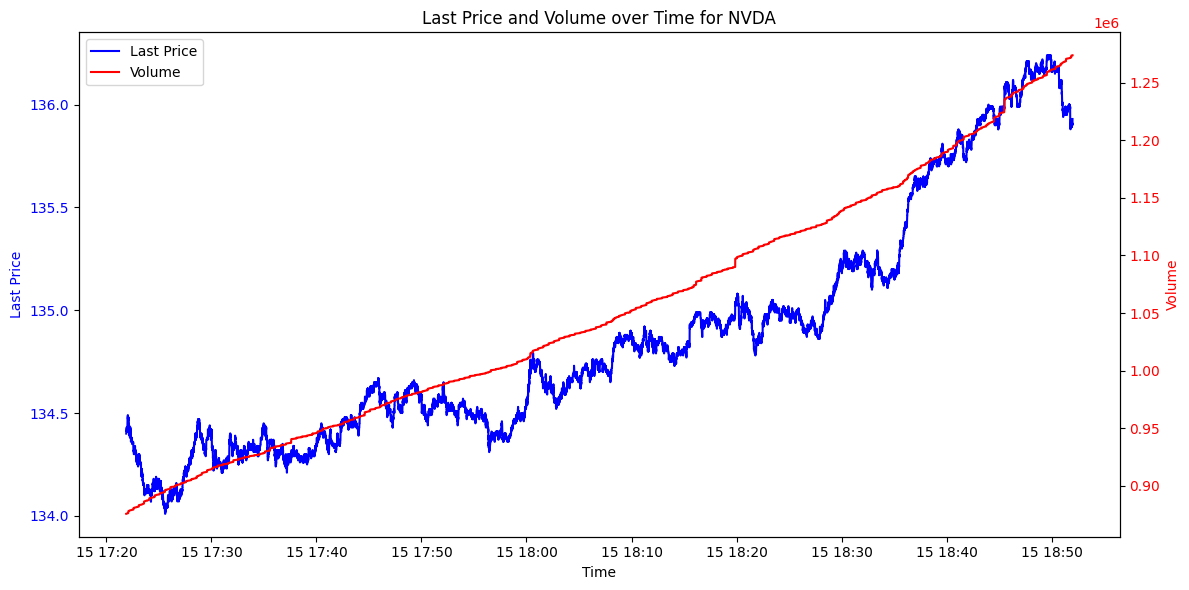

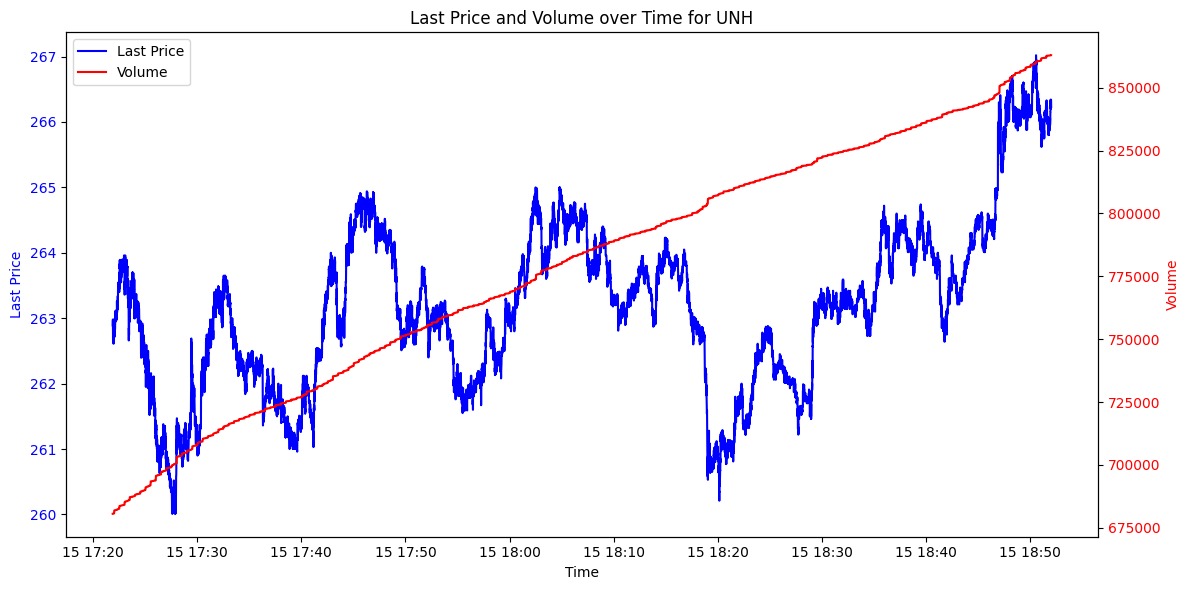

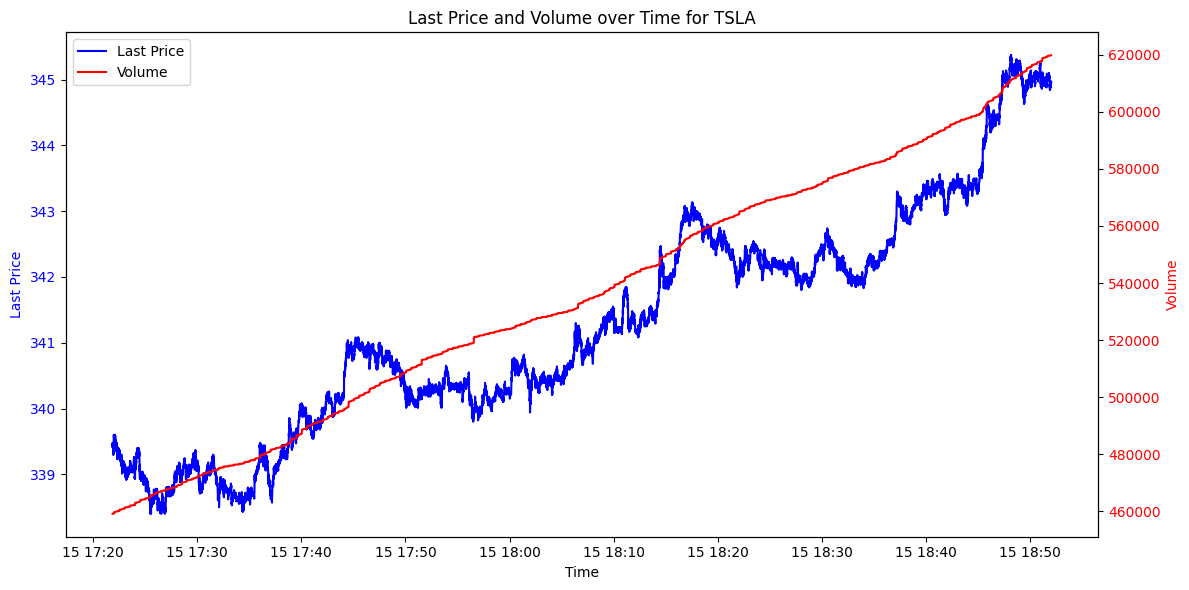

In [107]:
for sym in symbols:
    # Filter the data for the specific symbol
    df_sym = df[df['Symbol'] == sym]
    
    # Create a new figure and first axis for Last_price.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Last_price over time (using TS_Last_price).
    lns1 = ax1.plot(df_sym['TimeStamp'], df_sym['Last_price'], 
                    label='Last Price', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Last Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a twin Axes sharing the same x-axis for Volume.
    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_sym['TimeStamp'], df_sym['Volume'],
                    label='Volume', color='red')
    ax2.set_ylabel('Volume', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optionally, combine legends from both axes.
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')
    
    # Set a title and a bit of margin if desired.
    plt.title(f'Last Price and Volume over Time for {sym}')
    plt.tight_layout()
    plt.show()


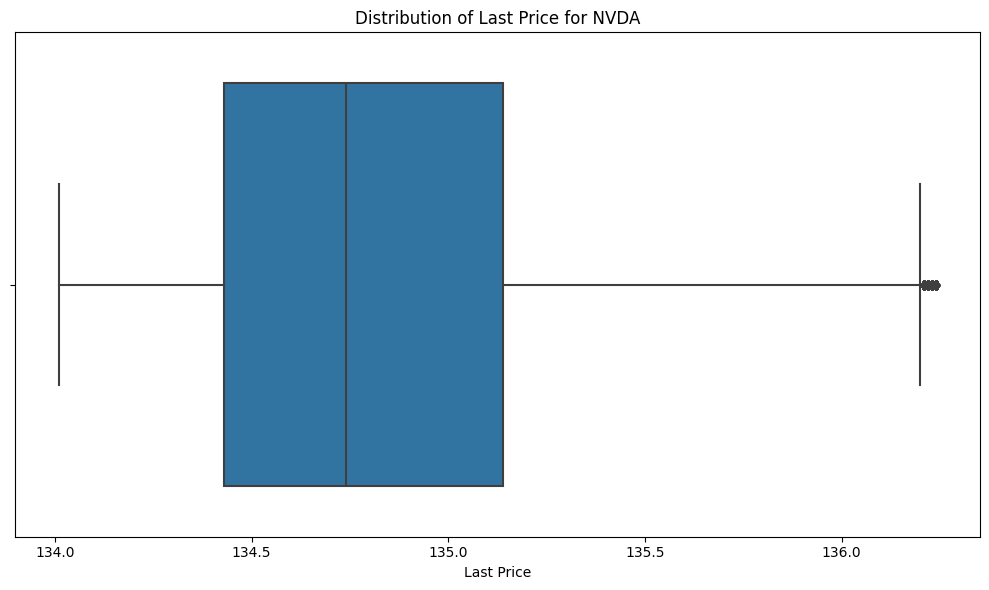

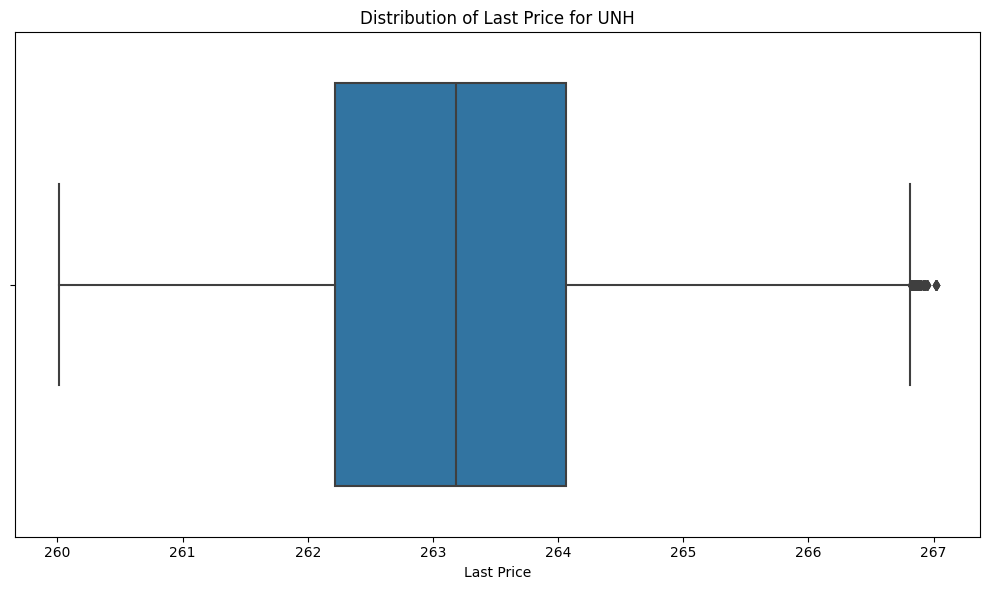

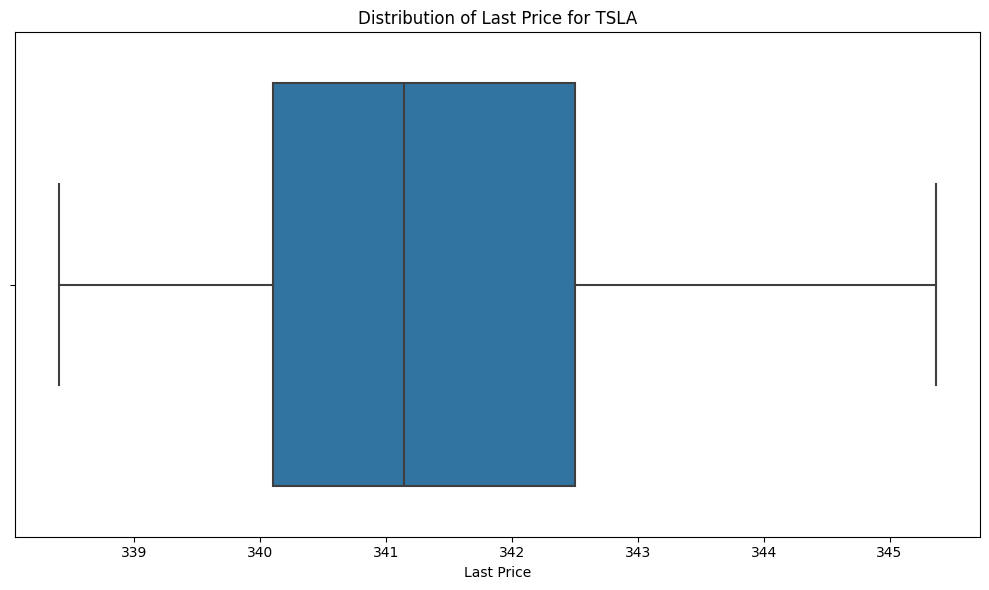

In [108]:
# Loop over each symbol
for sym in symbols:
    # Filter data for the specific symbol
    df_sym = df[df['Symbol'] == sym]
    
    # Create a new figure for the boxplot
    plt.figure(figsize=(10,6))
    
    # # Option 1: Using a single-variable boxplot
    sns.boxplot(x=df_sym['Last_price'])
    plt.xlabel('Last Price')
    
    # Option 2 (if you prefer to show the symbol category):  
    # sns.boxplot(x='Symbol', y='Last_price', data=df_sym)
    # This will display the symbol on the x-axis (though there is only one category).
    
    plt.title(f'Distribution of Last Price for {sym}')
    plt.tight_layout()
    plt.show()


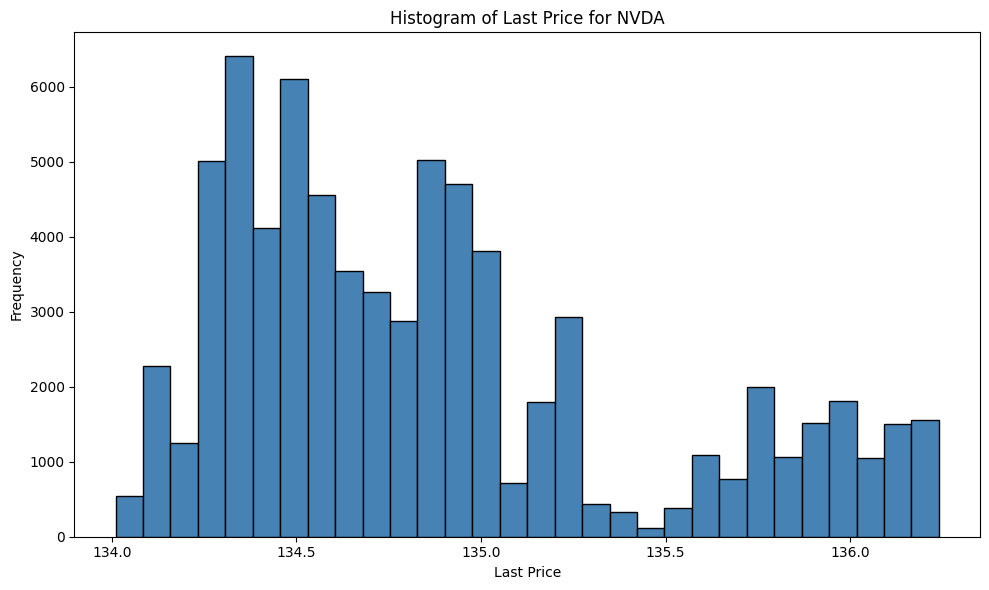

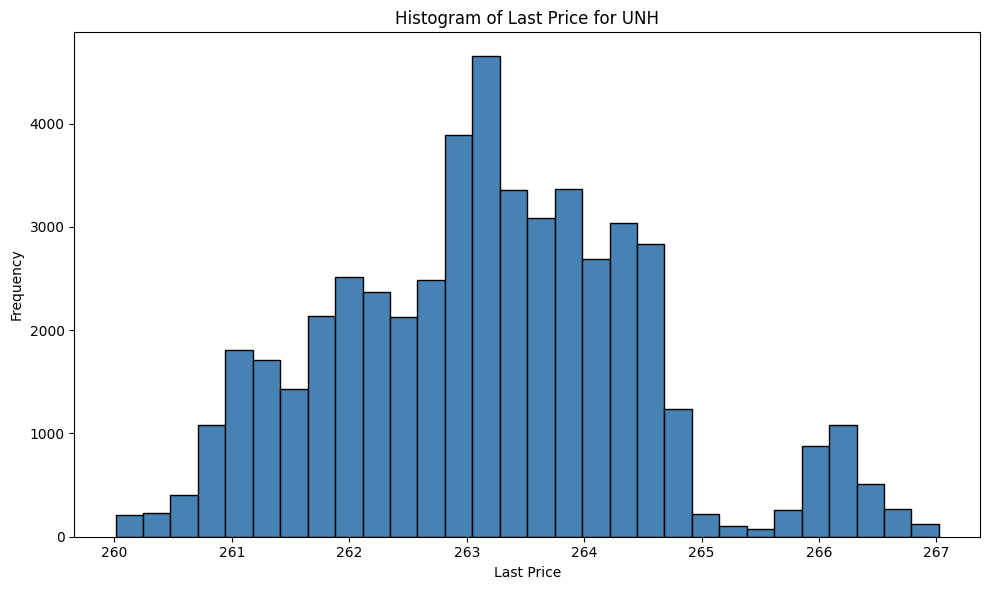

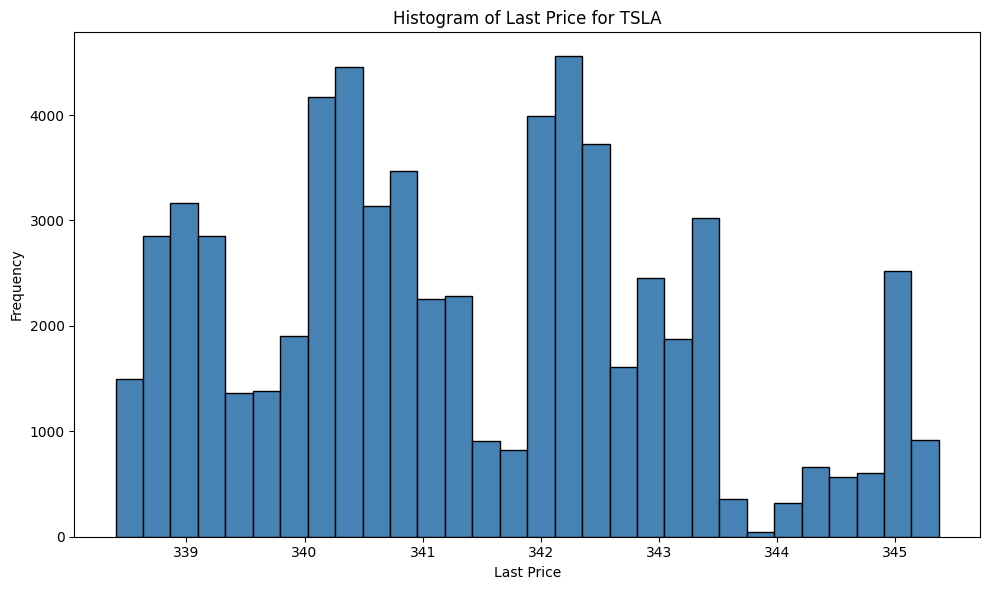

In [109]:
# Loop over each symbol and create an individual histogram.
for sym in symbols:
    df_sym = df[df['Symbol'] == sym]
    plt.figure(figsize=(10, 6))
    
    # Option 1: Using Matplotlib's plt.hist
    plt.hist(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
    # Option 2: Using Seaborn's histplot (uncomment if you prefer)
    # sns.histplot(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
    plt.xlabel('Last Price')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Last Price for {sym}')
    plt.tight_layout()
    plt.show()


In [110]:
# print(df[['TimeStamp', 'Last_price']].head(50))
